# Model 1a and 1b: Autoencoder

1. Model 1a: Unconditional autoencoder
2. Model 1b: Conditional autoencoder

In [42]:
from keras_tuner import HyperModel
import keras_tuner as kt

import numpy as np
import pandas as pd
#!pip install keras_tuner
#import keras_tuner

import keras
from keras import models, layers, metrics, Sequential
from keras.layers import Dense, BatchNormalization, Dropout
import tensorflow as tf
from keras.regularizers import l1,l2,l1_l2
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input, Dense, Multiply, Concatenate
from tensorflow.keras.models import Model

import tensorflow as tf
import random

import keras_tuner
from keras_tuner import HyperModel
import keras_tuner as kt

def import_firm(q=0.2, scaled = False):
    path = "dataset/"
    df_firm = pd.read_pickle(path+'firm_df49.pkl')
    df_firm.index = pd.to_datetime(df_firm.index).to_period('M')
    # chars_data 
    chars_data = df_firm.copy()
    factors = chars_data.groupby('jdate').apply(
        lambda x: x[char_core].apply(lambda z: x[z >= z.quantile(1 - q)]['predicted_return'].mean() -
                    x[z <= z.quantile(q)]['predicted_return'].mean()))
    if scaled == True:
        scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
        factors_scaled = scaler.fit_transform(factors)
        factors_scaled_df = pd.DataFrame(factors_scaled, columns=factors.columns)
        factors_scaled_df.index = factors.index
        merged_latent = pd.merge(df_firm, factors_scaled_df, left_on='jdate', right_on=factors_scaled_df.index, how='inner')
    elif scaled == False:
        merged_latent = pd.merge(df_firm, factors, left_on='jdate', right_on=factors.index, how='inner')
    merged_latent.index = df_firm.index
    return merged_latent

merged_latent49 = import_firm(q=0.2, scaled = False)
path = "dataset/"
merged_latent49.to_pickle(path+'merged_latent49.pkl')


In [43]:
char_core = [
          'acc','agr','beta','bm','cash','cashpr','cfp','chatoia','chcsho','chfeps','chinv',
          'chmom','chpmia','chtx','currat','depr','dy','ear','ep','gma','grcapx','grltnoa',
          'ill','indmom','invest','lev','lgr','maxret','mom12m','mom1m','mom36m','mve','nincr',
          'orgcap','pchgm_pchsale','pchsale_pchinvt','pchsale_pchrect','pchsale_pchxsga',
          'retvol','roaq','roavol','roeq','salecash','saleinv','sgr','sp','std_dolvol','std_turn','turn']

#merged_latent.to_pickle('merged_latent49.pkl')
merged_latent49 = pd.read_pickle("merged_latent49.pkl")

# merged data 1
firm_col = merged_latent49.columns.tolist()[18:18+49]
latent_col = merged_latent49.columns.tolist()[18+49+1:]
print(len(firm_col), len(latent_col))

49 49


In [44]:
df_train = merged_latent49[merged_latent49.index < pd.Period((str(1995)+"-1"),freq='M')]
df_val = merged_latent49[(merged_latent49.index >= pd.Period((str(1995)+"-1"),freq='M')) & (merged_latent49.index < pd.Period((str(2000)+"-1"),freq='M'))]
df_test = merged_latent49[merged_latent49.index >= pd.Period((str(2000)+"-1"),freq='M')]

merged_train_firm = df_train[firm_col]
merged_train_latent = df_train[latent_col]
merged_train_y = df_train['predicted_return']
print(merged_train_firm.shape, merged_train_latent.shape, merged_train_y.shape)

merged_val_firm = df_val[firm_col]
merged_val_latent = df_val[latent_col]
merged_val_y = df_val['predicted_return']
print(merged_val_firm.shape, merged_val_latent.shape, merged_val_y.shape)

merged_test_firm = df_test[firm_col]
merged_test_latent = df_test[latent_col]
merged_test_y = df_test['predicted_return']
print(merged_test_firm.shape, merged_test_latent.shape, merged_test_y.shape)

(88347, 49) (88347, 49) (88347,)
(31851, 49) (31851, 49) (31851,)
(90007, 49) (90007, 49) (90007,)


# Model Design

1. Multi-input with conditional autoencoder
2. Multi-input with standard autoencoder


In [46]:
def my_metric_fn(y_true, y_pred):
    num = tf.reduce_mean(tf.square(y_true - y_pred))
    den = tf.reduce_mean(tf.square(y_true))
    return 1 - num / den

def multi_input_model(num_input, dropout_, l1_reg_, l2_reg_):
    dropout = dropout_
    l1_reg = l1_reg_
    l2_reg =l2_reg_
    input1 = Input(shape=(num_input,))
    input2 = Input(shape=(num_input,))
    x1 = Dense(4, activation='relu')(input2)
    x1 = Dense(num_input, activation='relu')(x1)

    merged = Multiply()([input1, x1])
    x2 = Dense(32, activation='relu')(merged)
    x2 = Dense(16, activation='relu')(x2)
    #x2 = Dense(8, activation='relu')(x2)
    output = Dense(1, activation='linear')(x2)
    model = Model(inputs=[input1, input2], outputs=output)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.92) 
    #model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=[my_metric_fn])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[my_metric_fn])
    return model 

def Autoencoder(num_input,lr=0.0001, acti='relu'):
    input_img = Input(shape=(num_input, ))
    encoded1 = Dense(4, activation=acti)(input_img)
    decoded1 = Dense(num_input, activation=acti)(encoded1)
    
    autoencoder = Model(inputs=input_img, outputs=decoded1)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    autoencoder.compile(loss='mean_absolute_error',optimizer=opt, metrics=[my_metric_fn])
   #autoencoder.compile(loss='mean_squared_error', optimizer=opt, metrics=[my_metric_fn])
    return autoencoder

In [47]:
## Conditional Autoencoder
import random 
seed_list = [458, 165, 530, 564, 590, 560, 829, 170, 376, 176]
yhat_df = pd.DataFrame()

for random_seed in seed_list:
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    autoencoder = Autoencoder(num_input=merged_train_latent.shape[1])
    autoencoder.fit(merged_train_latent, merged_train_latent, 
                epochs = 20, batch_size = 216,
                validation_data = (merged_val_latent, merged_val_latent),
                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=1)])
 
    model = multi_input_model(num_input=merged_train_latent.shape[1], 
                              dropout_=0.2, 
                              l1_reg_=0.01, 
                              l2_reg_=0.01,)
    model.layers[1].set_weights(autoencoder.layers[1].get_weights())
    #model.layers[3].set_weights(autoencoder.layers[2].get_weights())
    model.layers[1].trainable = False
   # model.layers[3].trainable = False
    model.fit([merged_train_latent, merged_train_firm], merged_train_y,
                   epochs=50,
                   validation_data=([merged_val_latent, merged_val_firm], merged_val_y),
                   callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=1)])
    print(model.evaluate([merged_test_latent, merged_test_firm], merged_test_y))
    y_hat = model.predict([merged_test_latent, merged_test_firm]).reshape(-1)
    yhat_df[random_seed] = y_hat
    print()

Epoch 1/20
410/410 [==============================] - 0s 554us/step - loss: 0.0176 - my_metric_fn: 0.0398 - val_loss: 0.0201 - val_my_metric_fn: 0.0170
Epoch 2/20
410/410 [==============================] - 0s 384us/step - loss: 0.0169 - my_metric_fn: 0.1143 - val_loss: 0.0198 - val_my_metric_fn: 0.0427
Epoch 3/20
410/410 [==============================] - 0s 383us/step - loss: 0.0165 - my_metric_fn: 0.1518 - val_loss: 0.0196 - val_my_metric_fn: 0.0639
Epoch 4/20
410/410 [==============================] - 0s 385us/step - loss: 0.0162 - my_metric_fn: 0.1709 - val_loss: 0.0195 - val_my_metric_fn: 0.0753
Epoch 5/20
410/410 [==============================] - 0s 385us/step - loss: 0.0161 - my_metric_fn: 0.1830 - val_loss: 0.0194 - val_my_metric_fn: 0.0855
Epoch 6/20
410/410 [==============================] - 0s 384us/step - loss: 0.0159 - my_metric_fn: 0.1976 - val_loss: 0.0192 - val_my_metric_fn: 0.0950
Epoch 7/20
410/410 [==============================] - 0s 383us/step - loss: 0.0157 - my_

In [49]:
# Print out Predictive R^2


y_predict = yhat_df.mean(axis=1).values.reshape(-1)
y_real = merged_test_y
a = np.mean(np.square(y_predict -  y_real))
b = np.mean(np.square(y_real))
R2 = 1-a/b
print(f"R^2 is {R2}")

path_y = '\predict'
yhat_df.to_pickle(path_y+"model1a49.pkl")

# When the loss function for the autoencoder is 'mean square error'
# 0.15967752388383383
# The result of unconditional autoencoder with activation sigmoid 
# is 0.1394997674169679

R^2 is 0.1599859659564311


In [39]:
# Print out Predictive R^2
y_predict = yhat_df.mean(axis=1).values.reshape(-1)
y_real = merged_test_y
a = np.mean(np.square(y_predict -  y_real))
b = np.mean(np.square(y_real))
R2 = 1-a/b
print(f"R^2 is {R2}")

path_y = '\predict'
yhat_df.to_pickle(path_y+"model1a49.pkl")
# 0.15967752388383383
# The result of unconditional autoencoder with activation sigmoid 
# is 0.1394997674169679

R^2 is 0.15967752388383383


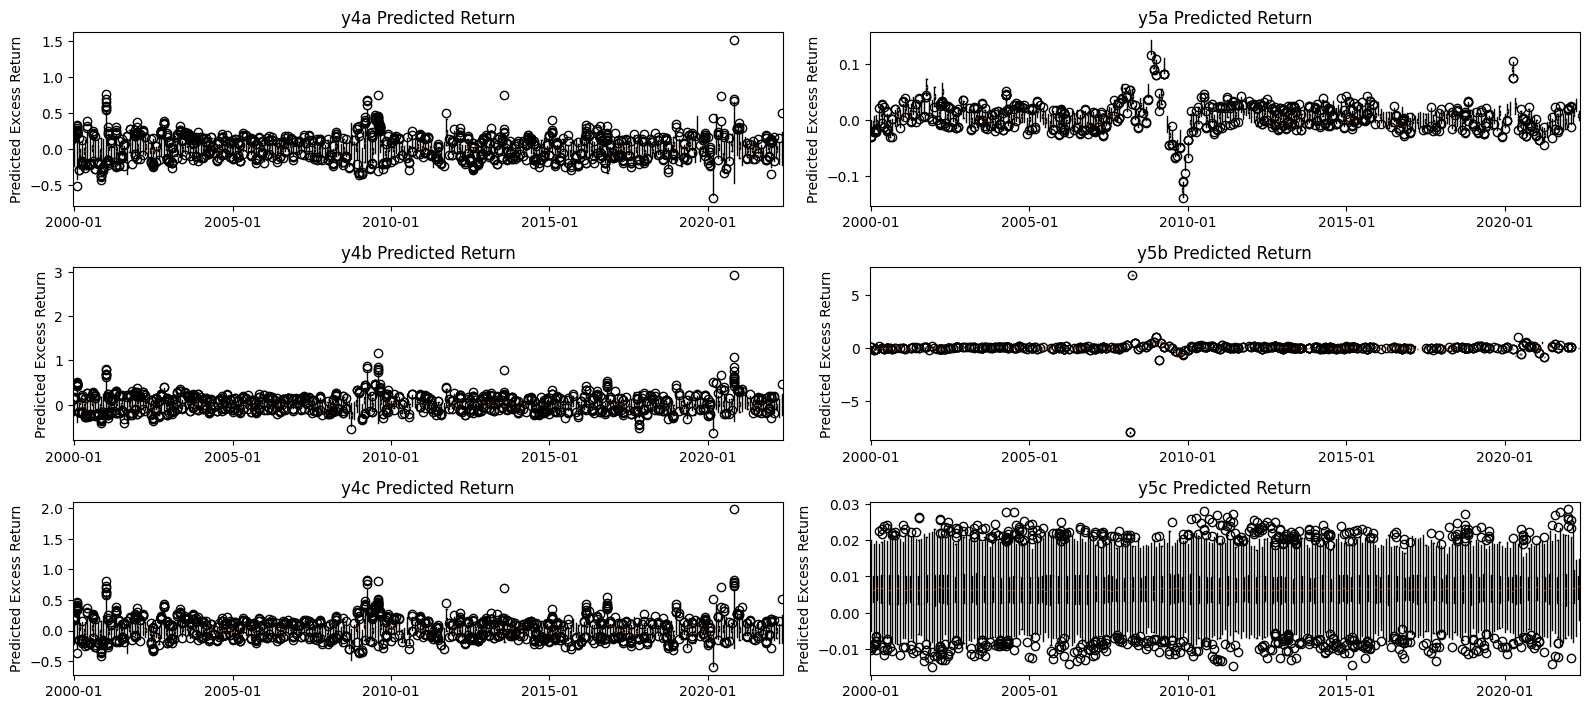

In [ ]:
plt.figure(figsize=(16, 14))

boxplot(num=621, model_name="y4a",label_name = "y4a")
boxplot(num=622, model_name="y5a",label_name = "y5a")
boxplot(num=623, model_name="y4b",label_name = "y4b")
boxplot(num=624, model_name="y5b",label_name = "y5b")
boxplot(num=625, model_name="y4c",label_name = "y4c")
boxplot(num=626, model_name="y5c",label_name = "y5c")


## Conditional autoencoder

In [40]:
## Conditional Autoencoder
seed_list = [458, 165, 530, 564, 590, 560, 829, 170, 376, 176]
yhat_df = pd.DataFrame()

for random_seed in seed_list:
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    model = multi_input_model(num_input=merged_train_latent.shape[1], 
                              dropout_=0., # 0.2
                              l1_reg_=0.0,# 0.01
                              l2_reg_=0.0,# 0.01
                              )
    model.fit([merged_train_latent, merged_train_firm], merged_train_y,
              epochs=50,batch_size = 128,
              validation_data=([merged_val_latent, merged_val_firm], merged_val_y),
              callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=1)])
    print(model.evaluate([merged_test_latent, merged_test_firm], merged_test_y))
    y_hat = model.predict([merged_test_latent, merged_test_firm]).reshape(-1)
    yhat_df[random_seed] = y_hat
    print()

Epoch 1/50
691/691 [==============================] - 1s 627us/step - loss: 0.0119 - my_metric_fn: 0.0235 - val_loss: 0.0140 - val_my_metric_fn: 0.0371
Epoch 2/50
691/691 [==============================] - 0s 575us/step - loss: 0.0110 - my_metric_fn: 0.0978 - val_loss: 0.0138 - val_my_metric_fn: 0.0358
Epoch 3/50
691/691 [==============================] - 0s 516us/step - loss: 0.0105 - my_metric_fn: 0.1335 - val_loss: 0.0138 - val_my_metric_fn: 0.0316
Epoch 4/50
2813/2813 [==============================] - 1s 255us/step - loss: 0.0137 - my_metric_fn: 0.0620
[0.013681003823876381, 0.06202872470021248]
2813/2813 [==============================] - 1s 228us/step

Epoch 1/50
691/691 [==============================] - 1s 590us/step - loss: 0.0120 - my_metric_fn: 0.0166 - val_loss: 0.0142 - val_my_metric_fn: 0.0283
Epoch 2/50
691/691 [==============================] - 0s 494us/step - loss: 0.0114 - my_metric_fn: 0.0671 - val_loss: 0.0140 - val_my_metric_fn: 0.0370
Epoch 3/50
2813/2813 [======

In [41]:
# Conditional Autoencoder Print out Predictive R^2
y_predict = yhat_df.mean(axis=1).values.reshape(-1)
y_real = merged_test_y
a = np.mean(np.square(y_predict -  y_real))
b = np.mean(np.square(y_real))
R2 = 1-a/b
print(f"R^2 is {R2}")

path_y = '\predict'
yhat_df.to_pickle(path_y+"model1b49.pkl")
# 0.14715711806321052

R^2 is 0.14715711806321052
